In [1]:
import util_match
import pickle
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
import os

In [2]:
bool_plot = True   # set to false if gathering matching data

# Reading data
In case that we get different EoS using the same folder parameters in the future, I'll also keep track of the EoS file. For this I think the file modification time is sufficient.

Unfinished runs are detected by mismatches in the length of beta.

We are currently not planning to run simulation for kagome lattice because it is too expensive.

How I treat folder parameters:
* $\mu$, $V$, $t_p$ and $shift$ are things we expect to be different in a folder. All the other parameters should be the same; I include them in `folder_params_shared` and check for every folder.
    * Among them, $\mu$ is additionally saved in `data_in_measurements["mu"]`. I check that this indeed matches the one specified in the folder name.
    * For $V$, $t_p$ and $shift$, I don't do the filtering until all the data are loaded.
* I assume $t = 1$.

In [3]:
# I had to keep the data files in the download folder, otherwise the folder names are too long
data_folder = Path(r"C:\Users\ken92\Downloads\Shao-Wen Data")
# Interacting
geometry = "sawtooth" # "sawtooth", "kagome"
L_subregion = 50
chi_tenpy = 64
V_model = 3.0

# geometry specific parameters
tp_ST = 1.41421356237
shift_ST = -2.0

scan_name = f"ST_SL_I_L{L_subregion}_t1_tpsqrt2_shf{int(shift_ST)}_V{V_model}_chi{chi_tenpy}.tar"

In [4]:
N_sites = 2 * L_subregion
geom_spec_str = f"V{V_model}_tp{tp_ST}_shift{shift_ST}"
# For checking folder parameter consistency
tnpspc = {
    "geometry": geometry,
    "L": L_subregion,
    "chi": chi_tenpy,
}

Interacting and non-interacting data is stored differently and require different unpacking methods.

In [5]:
folder_params_shared = None
records_EoS = []
scan_folder = Path(data_folder, scan_name)
assert scan_folder.exists()

subfolder_list = [f for f in scan_folder.iterdir() if f.is_dir()]
print(f"found {len(subfolder_list)} folders")

first_betas = None
for i_f, sf_path in enumerate(subfolder_list):
    # Load data and store them as panda data rows
    filepath = Path(sf_path, "measurements.pkl")
    assert filepath.is_file()
    with open(filepath, "rb") as f:
        file_content = pickle.load(f)

    try:
        folder_params = util_match.parse_folder_name(sf_path)
        
        # Check mu consistency between folder name and file
        mu = file_content['mu']
        if not np.isclose(mu, folder_params['mu']):
            raise(ValueError(f"mu_folder = {folder_params['mu']} doesn't agree with mu_file = {mu}"))
        else:
            folder_params.pop("mu")
        
        # Check shared folder parameters
        V = folder_params.pop("V")
        shift = folder_params.pop("shift")
        tp = folder_params.pop("tp")
        if folder_params_shared is None:
            folder_params_shared = folder_params.copy()
            for k, v in tnpspc.items():
                if folder_params_shared[k] != v:
                    raise(ValueError(f"mismatch in tenpy parameter {k}: specified {v}, but {folder_params_shared[k]} from folder"))
        else:
            if folder_params != folder_params_shared:
                print(folder_params)
                print(folder_params_shared)
                raise(ValueError("mismatch in folder parameters"))

        # Save data
        for i_b, beta in enumerate(file_content['betas']):
            S2, n_avg, energy, eps, ov, max_chi, trace, runtime = file_content['data'][i_b, :]
            records_EoS.append({
                "mu": file_content['mu'],
                "beta": beta,
                "S2": S2,
                "n_avg": n_avg,
                "energy": energy,
                "eps": eps,
                "ov": ov,
                "max_chi": max_chi,
                "trace": trace,
                "runtime": runtime,
                "file_mtime": os.path.getmtime(filepath),
                "V": V,
                "shift": shift,
                "tp": tp
            })
    except ValueError as e:
        print(filepath)
        raise(e)

    # Check beta length and print warnings if they don't look right
    if first_betas is None:   # assuming that the first subfolder has the right length of data
        first_betas = file_content['betas']
        continue
    else:
        len_good = (len(file_content['betas']) == len(first_betas))      # length is good
        if len_good: # content is also good
            if np.allclose(file_content['betas'], first_betas):
                continue
    print(f"beta doesn't agree for {filepath}")
    print(f"getting {file_content['betas']}")

df_all_data = pd.DataFrame.from_records(records_EoS)

found 61 folders


## Filter parameters using Dataframe
Currently I only consider joined systems with the same interaction strength everywhere.

### Specify filter parameters

In [6]:
filter_params = {"V": V_model, "shift": shift_ST, "tp": tp_ST}

In [7]:
df_filtered = df_all_data.query(f"(V == {V_model}) & (shift == {shift_ST})")
idx_list = ["mu", "beta"]
df_filtered = df_filtered.set_index(idx_list).sort_index()

# df_filtered

## Plots
Even for finite interaction strengths, we still see a trace of the flat band in the $S_{2, avg}$ plot. For example, for the $V = 1$, shift $= 2$ single layer sawtooth, we see an enhancement in entropy around $\mu = 0.5$. I would have naively guessed that this should happen at $\mu = 0.25$ instead by looking at the completely localized states (CLS):
* The wave function of CLS lives on two neighboring teeth, and has values of $1 / \sqrt(2)$ on the shared A site, and $1 / 2$ on the two B sites.
    * i.e. there's half a particle on the A site and a quarter of a particle each on the B sites
* Each of the link then gets an energy of $1/2 \cdot 1/4 \cdot V = 1/8$.
* There are two links, so the shift in energy for each CLS is $1/8 \cdot 2 = 1/4$.

In [8]:
mu_vals  = df_filtered.index.get_level_values("mu").unique().to_numpy()
beta_vals = df_filtered.index.get_level_values("beta").unique().to_numpy()
n_grid = df_filtered["n_avg"].unstack("beta").loc[mu_vals, beta_vals].to_numpy()    # particle per site
s2_grid = df_filtered["S2"].unstack("beta").loc[mu_vals, beta_vals].to_numpy()       # Renyi 2-entropy per particle
e_grid = df_filtered["energy"].unstack("beta").loc[mu_vals, beta_vals].to_numpy()   # energy per particle
eps_grid = df_filtered["eps"].unstack("beta").loc[mu_vals, beta_vals].to_numpy()    # sum of all discarded Schmidt values squared
ov_grid = df_filtered["ov"].unstack("beta").loc[mu_vals, beta_vals].to_numpy()      # lower bound for the overlap

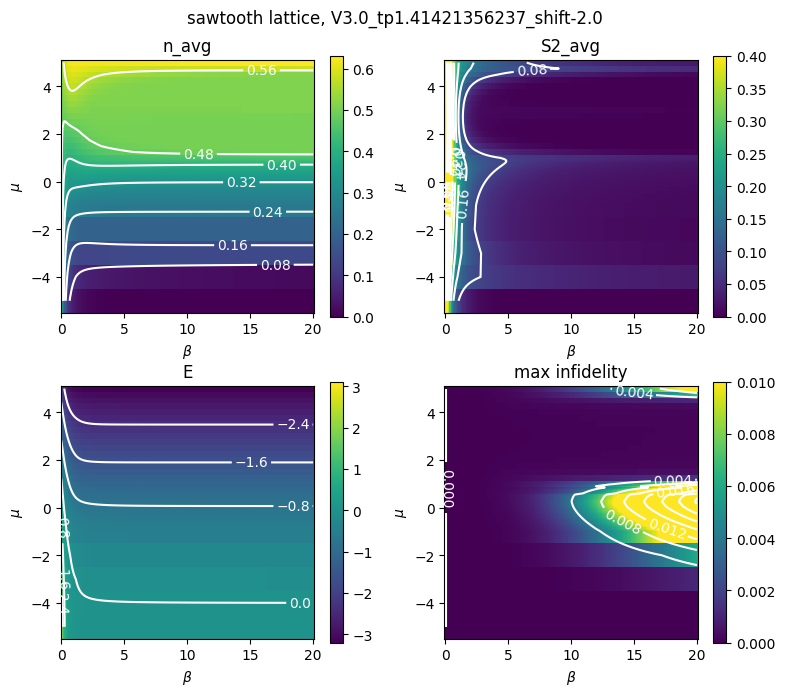

In [18]:
if bool_plot:
    fig_ns, axes_ns = plt.subplots(2, 2, figsize = (8, 7))
    for ax, vals, str_label, clim in zip(axes_ns.flatten(),
                        [n_grid, s2_grid, e_grid, 1 - ov_grid],
                        ["n_avg", "S2_avg", "E", "max infidelity"],
                        [None, (0., 0.4), None, (0, 0.01)],):
        img = ax.pcolormesh(beta_vals, mu_vals, vals, clim = clim)
        ax.set_box_aspect(1)
        ax.set_title(str_label)
        ax.set_xlabel(r"$\beta$")
        ax.set_ylabel(r"$\mu$")
        cntr = ax.contour(beta_vals, mu_vals, vals, colors = "white", linestyles = "solid", levels = 8)
        ax.clabel(cntr, inline = True)
        fig_ns.colorbar(img, ax = ax)
    fig_ns.suptitle(f"{geometry} lattice, {geom_spec_str}")
    fig_ns.tight_layout()

# Actual calculations
Goal: given our equations of state $n(\mu, \beta)$ and $s_2(\mu, \beta)$, achieve some filling factor $n_s$ in the system for different $(N_{tot}, S_{tot})$
(This also fixes $N_r = N_{tot} - 2 n_s L$, or equivalently $n_r = 2n - n_s$)
1. Find $\mu_{s, r} = \mu(\beta) |_{n(\mu, \beta) = n_{s, r}}$ by inverting $n(\mu, \beta)$. I can do this for all $\beta$.
2. Find $s_2(\mu_{s, r}, \beta)$. As I vary $\beta$ I should get a smooth change in $S_2 = 2 L (s_2(\mu_s) + s_2(\mu_r))$, so the scan in $S_{tot}$ comes for free.
3. Do this for different $N_{tot}$. Now I've in principle done a scan in the $(N, S)$ space.

(Take $L_s = L_r = L$ for now, where $L$ is the number of unit cells, so there are $2L$ sites in each subregion)

Here we get $(n_s; N_{tot}, \beta) \rightarrow (\mu_s, \mu_r, S_{tot})$, where I additionally define
* $V_{offset} = \mu_r - \mu_s$ is the offset potential required to achieve $n_s$.
* $\mu \equiv \mu_r$ --- this one is somewhat arbitrary. Effectively, I'm assuming that $V_{offset}$ is a potential that only increases the potential energy in the system region, while leaving the reservoir region intact. This is the case for our experimental setup, since our DMD light is blue-detuned.
* $n = N_{tot} / 4L$

I write a semicolon for $n_s$ because it is not really a thermodynamic variable in the usual sense, but not including that gives one the wrong impression that the relation is underdetermined. (i.e. I want to have the same number of values on both side)

## $N_{tot}$ and $S_{tot}$ matching
We'll see how well ChatGPT implement this algorithm in 48 seconds.

### Scan $N_{tot}$ (jump here to change $n_s$)

In [10]:
# idx_beta_scan = (beta_vals >= 2.)       # Otherwise the contours will be concentrated at small beta where things are boring
idx_beta_scan = (beta_vals >= -1.)      # All beta, use this for the .csv file
beta_scan = beta_vals[idx_beta_scan]
n_s_tar = 0.4   # target filling in the system

N_tot_arr = np.arange((n_s_tar + 0.) * N_sites, (n_s_tar + 1) * N_sites + 1, dtype=int)

In [11]:
N_s_tar = n_s_tar * N_sites
assert N_s_tar <= N_tot_arr[-1], f"there must be at least {N_s_tar} particles"

In [12]:
N_beta = beta_scan.size
N_Ntot = N_tot_arr.size

mu_s_all  = np.full((N_Ntot, N_beta), np.nan)
mu_r_all  = np.full((N_Ntot, N_beta), np.nan)
s2_s_all  = np.full((N_Ntot, N_beta), np.nan)
s2_r_all  = np.full((N_Ntot, N_beta), np.nan)
S2_tot_all = np.full((N_Ntot, N_beta), np.nan)
n_r_arr   = np.full(N_Ntot, np.nan)

for k, N_tot in enumerate(N_tot_arr):
    # global filling n and reservoir filling n_r
    n_global = N_tot / N_sites / 2.
    n_r = 2.0 * n_global - n_s_tar   # equivalently: N_tot/2L - n_s
    n_r_arr[k] = n_r

    # 1) invert n(mu, beta) to get mu_s(beta) and mu_r(beta)
    mu_s = util_match.invert_n_to_mu(mu_vals, beta_scan, n_grid[:, idx_beta_scan], n_s_tar)
    mu_r = util_match.invert_n_to_mu(mu_vals, beta_scan, n_grid[:, idx_beta_scan], n_r)

    mu_s_all[k, :] = mu_s
    mu_r_all[k, :] = mu_r

    # 2) evaluate s2 at those mus
    s2_s = util_match.s2_at_mu(mu_vals, beta_scan, s2_grid[:, idx_beta_scan], mu_s)
    s2_r = util_match.s2_at_mu(mu_vals, beta_scan, s2_grid[:, idx_beta_scan], mu_r)

    s2_s_all[k, :] = s2_s
    s2_r_all[k, :] = s2_r

    # 3) total S2
    S2_tot_all[k, :] = N_sites * (s2_s + s2_r)

dmu_all = mu_r_all - mu_s_all
mu_glob_all = mu_r_all
sigma2_s_all = s2_s_all / n_s_tar # entropy per particle
sigma2_r_all = s2_r_all / n_r_arr[:, np.newaxis]
sigma2_all = S2_tot_all / 2 / N_sites

In [13]:
for label, data in [("mu_s", mu_s_all), ("mu_r", mu_r_all), ("s2_s", s2_s_all), ("s2_r", s2_r_all)]:
    if np.all(np.isnan(data)):
        raise(ValueError(f"No legal values for {label} within the range of input"))

We are interested in knowing when we can realize $\sigma_r > \sigma_s$. I'll define a dimensionless figure of merit

$\varsigma \equiv \sigma_s / s - 1 = (\sigma_s - \sigma_r) / (\sigma_s + \sigma_r)$ (assume $L_r = L_s$)

that measures the decrease in entropy, measured in entropy per particle if there were no offset. $\varsigma < 0$ indicates cooling effect.

In [14]:
varsigma_all = sigma2_s_all / sigma2_all - 1
min_varsigma = np.nanmin(varsigma_all.flatten())    # best cooling obtained

# masking arrays derived from varsigma
varsigma_all_nonan = np.nan_to_num(varsigma_all)
mask_alpha_cooling = np.minimum(varsigma_all_nonan, 0.) / min_varsigma

In [15]:
min_varsigma

np.float64(0.5376071448784467)

### Plots
The amount of cooling is, of course, shaded in red, in each axes. The last axes is a standalone visualization for it that has a fixed color range.
* $s_s$ plot is by definition boring, since $N_{tot}$ doesn't change $n_s$.
* $s_r$ plot has more feature because $n_r$ depends on $N_{tot}$.
* $S_{tot}$
* $\mu$
* $V_{offset}$ tells us the required offset we need to achieve $n_s$ in the system.
* $\varsigma$: the red grids in other axeses are scaled to the maximum amount of cooling. This one always use the same scale for comparison between different input parameters.

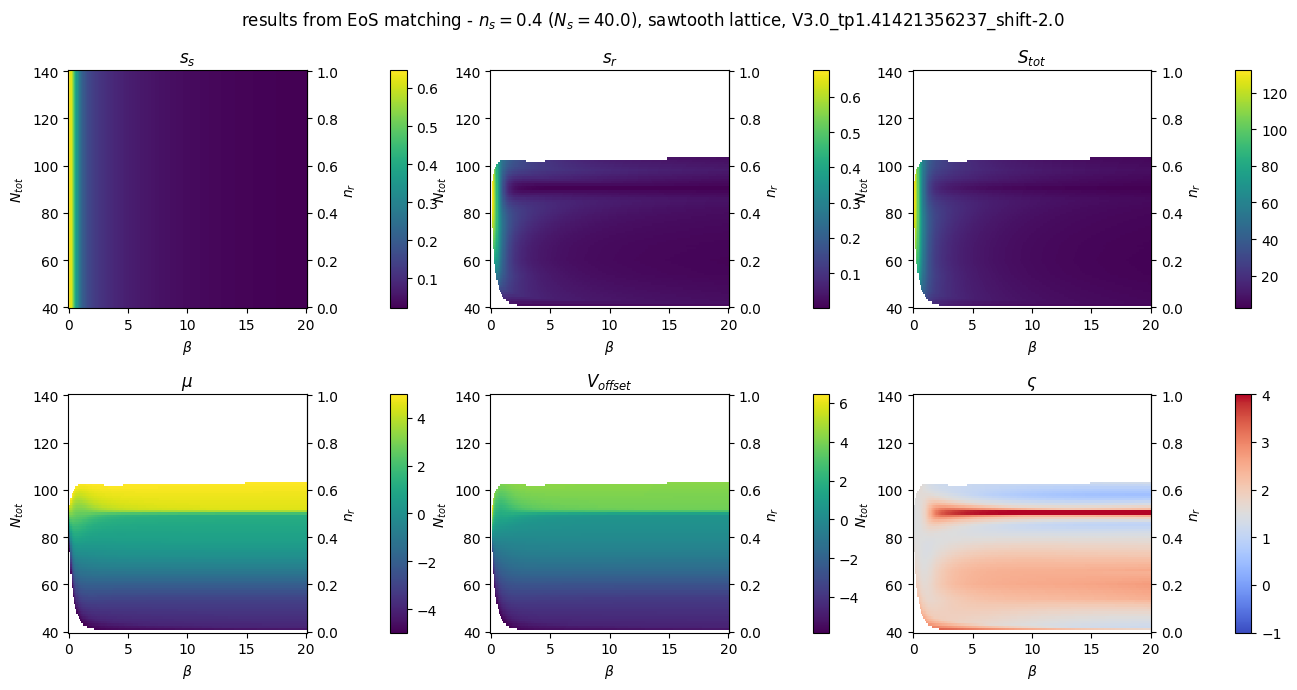

In [16]:
if bool_plot:
    fig_eos, axes_eos_all = plt.subplots(2, 3 * 2, figsize = (13, 7), gridspec_kw = {"width_ratios": [15, 1] * 3})
    axes_eos = axes_eos_all[:, ::2]
    axes_eos_cb = axes_eos_all[:,1::2]
    alpha_cooling_max = 0.
    for ax, ax_cb, vals, cmap, str_label, clim in zip(axes_eos.flatten(), axes_eos_cb.flatten(),
                        [s2_s_all, s2_r_all, S2_tot_all, mu_glob_all, dmu_all, varsigma_all],
                        ["viridis", "viridis", "viridis", "viridis", "viridis", "coolwarm"],
                        [r"$s_s$", r"$s_r$", r"$S_{tot}$", r"$\mu$", r"$V_{offset}$", r"$\varsigma$"],
                        [None, None, None, None, None, (-1, 4)]):
        img = ax.pcolormesh(beta_scan, N_tot_arr, vals, clim = clim, cmap = cmap)
        ax.set_box_aspect(1)
        ax.set_title(str_label)
        ax.set_xlabel(r"$\beta$")
        ax.set_ylabel(r"$N_{tot}$")
        ryax = ax.secondary_yaxis('right', functions = (lambda x: (x - N_s_tar) / (N_sites), lambda x: x * N_sites + N_s_tar))
        ryax.set_ylabel(r"$n_r$")
        # cntr = ax.contour(beta_scan, N_tot_arr, vals, colors = "white", linestyles = "solid", levels = 10)
        # ax.clabel(cntr, inline = True)
        fig_eos.colorbar(img, cax = ax_cb, fraction = 0.5, location = 'right')
        if str_label != r"$\varsigma$" and not np.isclose(alpha_cooling_max, 0.):
            ax.pcolormesh(beta_scan, N_tot_arr, np.ones_like(vals), clim = (0, 1), color = "red",# lw = 0.,
                        alpha = mask_alpha_cooling * alpha_cooling_max)
    fig_eos.suptitle(rf"results from EoS matching - $n_s =${n_s_tar} ($N_s =${N_s_tar}), {geometry} lattice, {geom_spec_str}")
    fig_eos.tight_layout(w_pad = 0.1)

Now, we scanned $\beta$ because it is easier to do, but we will be more interested in scanning total entropy. This is done in `matching_result_inverter.ipynb`.

### Building the matching results Dataframe

In [17]:
raise(Exception("Imma stop here"))  # comment this out to actually save data

Exception: Imma stop here

In [ ]:
records_matching = []
for i_beta, beta in enumerate(beta_scan):
    for i_Ntot, Ntot in enumerate(N_tot_arr):
        records_matching.append({
            "beta": beta,
            "Ntot": Ntot,
            "n_s": np.round(n_s_tar, 4),
            "n_r": n_r_arr[i_Ntot],
            "mu_s": mu_s_all[i_Ntot, i_beta],
            "mu_r": mu_r_all[i_Ntot, i_beta],
            "V_offset": dmu_all[i_Ntot, i_beta],
            "mu_glob": mu_glob_all[i_Ntot, i_beta],
            "s2_s": s2_s_all[i_Ntot, i_beta],
            "s2_r": s2_r_all[i_Ntot, i_beta],
            "sigma2_s": sigma2_s_all[i_Ntot, i_beta],
            "sigma2_r": sigma2_r_all[i_Ntot, i_beta],
            "sigma2": sigma2_all[i_Ntot, i_beta],
            "S2_tot": S2_tot_all[i_Ntot, i_beta],
            "varsigma": varsigma_all[i_Ntot, i_beta],
        } | filter_params)

In [ ]:
df_matching_rslt = pd.DataFrame.from_records(records_matching)
# df_matching_rslt

### Save to .csv
I'll treat the following as input parameters:
* All the original folder parameters except for $\mu$.
* $\beta$, $N_{tot}$, $n_s$
* EoS file modification time

A new row of data is added for each input parameters. If an entry with the same input parameters already exists in `csv_path`, we compare if the obtained results agree with the existing ones. If not, we print a warning but leaves the original result unchanged and move on.

Saving everything to a single .csv makes the comparison very slow (several minutes), so I make a new .csv for each $V$, $t_p$, $shift$, and $n_s$. For parameters in the name of .csv, the parameter comparison is done when looking for an existing `csv_path`.

If all the input parameters are the same except for the file modification time, the original entry is replaced if `bool_overwrite_older_mtime = True`, or a new row is added if it is `False`.

In [ ]:
input_param_cols = [k for k in filter_params.keys()] + [
    "beta",
    "Ntot",
    "n_s",
]

Check the number of rows existed in .csv if this is something I've run before.

In [ ]:
matching_results_folder = Path(r"C:\Users\ken92\Downloads\Shao-Wen Data\matching_results",
                               scan_name.removesuffix(".tar"))
matching_results_folder.mkdir(exist_ok = True)
csv_name = f"ns{np.round(n_s_tar, 4)}.csv"
csv_path = Path(matching_results_folder, csv_name)

df_matching_rslt.to_csv(csv_path, index = False)
# util_match.update_eos_csv(
#     df_new = df_matching_rslt,
#     csv_path = csv_path,
#     param_cols = input_param_cols,
#     bool_overwrite_conflict = True,
# )